In [1]:
# Adam算法
''' 
本章我们已经学习了许多有效优化的技术。在本节讨论之前，我们先详细回顾⼀下这些技术：
    • 在 11.4节中，我们学习了：随机梯度下降在解决优化问题时⽐梯度下降更有效。(随机梯度下降)
    • 在 11.5节中，我们学习了：在⼀个⼩批量中使⽤更⼤的观测值集，可以通过向量化提供额外效率。这是
    ⾼效的多机、多GPU和整体并⾏处理的关键。(小批量随机梯度下降)
    • 在 11.6节中我们添加了⼀种机制，⽤于汇总过去梯度的历史以加速收敛。(动量法)
    • 在 11.7节中，我们通过对每个坐标缩放来实现⾼效计算的预处理器。(AdaGrad)
    • 在 11.8节中，我们通过学习率的调整来分离每个坐标的缩放。(RMSProp)
    
Adam算法 (Kingma and Ba, 2014)将所有这些技术汇总到⼀个⾼效的学习算法中。不出预料，作为深度学习
中使⽤的更强⼤和有效的优化算法之⼀，它⾮常受欢迎。但是它并⾮没有问题，尤其是 (Reddi et al., 2019)表
明，有时Adam算法可能由于⽅差控制不良⽽发散。在完善⼯作中，(Zaheer et al., 2018)给Adam算法提供了
⼀个称为Yogi的热补丁来解决这些问题。下⾯我们了解⼀下Adam算法。
--------------------------------------------------------------------------------------------
Adam算法的关键组成部分之⼀是：它使⽤指数加权移动平均值来估算梯度的动量和⼆次矩，即它使⽤状态
变量.它的设计灵感很清楚：⾸先，动量和规模在状态变量中清晰可⻅，它们相当独特的定义使我
们移除偏项（这可以通过稍微不同的初始化和更新条件来修正）。其次，RMSProp算法中两项的组合都⾮常
简单。最后，明确的学习率η使我们能够控制步⻓来解决收敛问题
'''
%matplotlib inline
import torch
from d2l import torch as d2l

In [2]:
''' 
从头开始实现Adam算法并不难。为⽅便起⻅，我们将时间步t存储在hyperparams字典中。除此之外，⼀切都
很简单
'''
def init_adam_states(feature_dim):
    v_w, v_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)+ eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

loss: 0.243, 0.009 sec/epoch


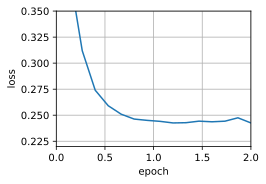

In [3]:
'现在，我们⽤以上Adam算法来训练模型，这⾥我们使⽤η = 0.01的学习率'
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adam, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

loss: 0.244, 0.007 sec/epoch


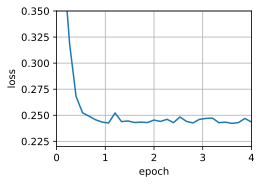

In [4]:
'此外，我们可以⽤深度学习框架⾃带算法应⽤Adam算法，这⾥我们只需要传递配置参数'
trainer = torch.optim.Adam
d2l.train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

loss: 0.244, 0.008 sec/epoch


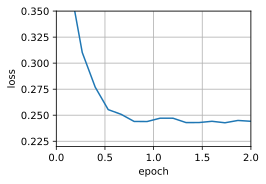

In [6]:
# Yogi
def yogi(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-3
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = s + (1 - beta2) * torch.sign(
                torch.square(p.grad) - s) * torch.square(p.grad) # sgn 符号函数,不在取决于偏差
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr) + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(yogi, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

In [ ]:
''' 
⼩结
• Adam算法将许多优化算法的功能结合到了相当强⼤的更新规则中
• Adam算法在RMSProp算法基础上创建的，还在⼩批量的随机梯度上使⽤EWMA
• 在估计动量和⼆次矩时，Adam算法使⽤偏差校正来调整缓慢的启动速度
• 对于具有显著差异的梯度，我们可能会遇到收敛性问题。我们可以通过使⽤更⼤的⼩批量或者切换到
改进的估计值st来修正它们。Yogi提供了这样的替代⽅案
'''